# Summarization model
Take a pre-trained model **MBARTRuSumGazeta** = https://huggingface.co/IlyaGusev/mbart_ru_sum_gazeta
The model is pre-trained on "Dataset for Automatic Summarization of Russian News" - https://arxiv.org/abs/2006.11063


# Setup

In [ ]:
!pip install transformers sentencepiece natasha

# Import

In [ ]:
from transformers import MBartTokenizer, MBartForConditionalGeneration
from natasha import (
    Segmenter,
    MorphVocab,
    NewsEmbedding,
    NewsMorphTagger,
    NewsNERTagger,
    Doc,
)
import re
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from google.colab import drive
from collections import defaultdict
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pymorphy2
from nltk.tokenize import word_tokenize  # Импортируем метод word_tokenize из библиотеки nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('russian')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
model_name = "IlyaGusev/mbart_ru_sum_gazeta"
tokenizer = MBartTokenizer.from_pretrained(model_name)
model_mbart = MBartForConditionalGeneration.from_pretrained(model_name).to("cpu")

# Classes

In [ ]:
class Summarization():
  def __init__(self, model):
    self.model = model


  def getSummary(self, text):
    self.input_ids = False
    self.output_ids = False
    self._input(text)
    return self._generate()


  def _input(self, text):
    self.input_ids = tokenizer(
      [text],
      max_length=600,
      truncation=True,
      return_tensors="pt",
    )["input_ids"].to("cpu")


  def _generate(self):
    self.output_ids = self.model.generate(
      input_ids = self.input_ids,
      no_repeat_ngram_size=4
    )[0]
    summary = tokenizer.decode(self.output_ids, skip_special_tokens=True)
    return summary

In [ ]:
class NLP_functions:
  def __init__(self):
    # Инициализация объектов, необходимых для обработки текста с использованием Natasha и Spacy.
    self.segmenter = Segmenter()  # Сегментация текста на предложения.
    self.morph_vocab = MorphVocab()  # Создание словаря морфологических данных.
    self.emb = NewsEmbedding()  # Получение векторных представлений слов.
    self.morph_tagger = NewsMorphTagger(self.emb)  # Морфологическая разметка текста.
    self.ner_tagger = NewsNERTagger(self.emb)  # Распознавание именованных сущностей.
    self.stop_words = ['АО «Эксперт РА', 'АКРА', 'Компания', 'Группа', 'Эксперт РА', 'Рейтинговое агентство', 'АО Эксперт РА', 'Кредитные', 'Оценка внешнее влияние', 'Группа.']
    self.lemmatizer = pymorphy2.MorphAnalyzer()  # Инициализируем лемматайзер MorphAnalyzer()

  def natasha_preprocessing(self, text) -> Doc:
    # Предобработка текста с использованием библиотеки Natasha.
    assert type(text) == str  # Проверка на входной текст.
    doc = Doc(text)  # Создание объекта Doc для текста.
    doc.segment(self.segmenter)  # Сегментация текста на предложения.
    doc.tag_morph(self.morph_tagger)  # Морфологическая разметка текста.
    doc.tag_ner(self.ner_tagger)  # Распознавание именованных сущностей.
    return doc

  def tag_ner(self, text) -> list:
    # Извлечение именованных сущностей из текста.
    doc = self.natasha_preprocessing(text)
    for span in doc.spans:
        span.normalize(self.morph_vocab)  # Нормализация именованных сущностей.
    return [(span.start, span.stop, span.normal, span.type) for span in doc.spans if span.normal not in self.stop_words]

  def cleantext(self, text):
    soup = BeautifulSoup(text)
    text = soup.get_text()
    text = re.sub(r'(http\S+)|(www\S+)|([\w\d]+www\S+)|([\w\d]+http\S+)', '', text)
    text = re.sub(r'[\n\t]', ' ', text).strip()  # Перенос, табуляция
    text = re.sub(r'[^\w\d\s\.\,]', ' ', text)  # Только слова, цифры, пробелы, точки и запятые
    text = re.sub(r'\s+', ' ', text)  # Удаляем двойные пробелы
    text = re.sub(r' [\.\,]', ' ', text)  # Только слова, цифры, пробелы, точки и запятые
    pat = "\s+([{}]+)".format(re.escape("\.\,"))
    text = re.sub("\s{2,}", " ", re.sub(pat, r"\1", text))
    return text

  def ners_top(self, ner_list):
    top = defaultdict(int)
    for ners in ner_list:
        for ner in ners:
            top[ner[2]] += 1
    top = sorted(top.items(), key=lambda x: x[1], reverse=True)
    return top

  def lemmatize_text(self, text):
        # Функция для лемматизации текста
        tokens = word_tokenize(text)
        # создаем переменную для хранения преобразованного текста
        text_new = ''
        for word in tokens:
            # с помощью лемматайзера получаем основную форму
            word = self.lemmatizer.parse(word)
            # добавляем полученную лемму в переменную с преобразованным текстом
            text_new = text_new + ' ' + word[0].normal_form
        return text_new

  def word_cloud(self, text):
        # Выводит облако лемматизированных тегов без стоп-слов
        text = self.lemmatize_text(text)
        # Генерируем облако слов и сохраняем в переменной cloud
        # cloud = WordCloud().generate(text)
        # Определяем параметр stopwords при создании объекта облака слов
        cloud = WordCloud(stopwords=stop_words, width=400, height=400).generate(text)
        # Выводим облако слов на экран
        plt.figure(figsize=(10, 10))
        plt.imshow(cloud)
        # Отключаем отображение осей
        plt.axis('off')

In [ ]:
#инициализация классов
model = Summarization(model_mbart)
nlp = NLP_functions()
i = 30

# Dataset

In [ ]:
#чтение датасета
drive.mount("/content/drive")
full_df = pd.read_excel("/content/drive/My Drive/Colab Notebooks/CRA_train_1200.xlsx")
df = full_df[i:i+10]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#обработка текста
df['pr_txt'] = df['pr_txt'].map(nlp.cleantext)
print(*list(df["pr_txt"]), sep='\n\n')

14 февраля 2023 г. Ведущий рейтинговый аналитик Юрова Алла Младший директор корпоративных рейтингов 7 495 122 22 55 109 yurova ra national.ru Второй рейтинговый аналитик Сергей Гришунин Управляющий директор рейтинговой службы 7 495 122 22 55 126 grishunin ra national.ru Дата Рейтингового комитета 10.02.2023 г. ПОВЫШЕН КРЕДИТНЫЙ РЕЙТИНГ Общество с ограниченной ответственностью Национальное Рейтинговое Агентство далее НРА, Агентство повысило кредитный рейтинг ООО ТК Нафтатранс Плюс до уровня по национальной рейтинговой шкале для Российской Федерации, прогноз Стабильный ПРОГНОЗ Стабильный прогноз предполагает с высокой долей вероятности сохранение текущего уровня рейтинга в течение следующих 12 двенадцати месяцев. РЕЗЮМЕ Повышение кредитного рейтинга далее Рейтинг ООО ТК Нафтатранс Плюс далее Компания до уровня обусловлено позитивным трендом размера операционного денежного потока и развитием системы управления рисками. Рейтинг Компании обусловлен 1 комфортным уровнем перманентного капитал

# **3 интструмента для ценки влияния текстовых факторов на рейтинг.**


# Summarization

In [ ]:
#суммаризация
df['summ'] = df['pr_txt'].map(model.getSummary)
print(*list(df["summ"]), sep='\n\n')

Повышение кредитного рейтинга ООО ТК Нафтатранс Плюс до уровня по национальной рейтинговой шкале для Российской Федерации обусловлено позитивным трендом размера операционного денежного потока и развитием системы управления рисками. Компания зарегистрирована в 2007 году в Новосибирске, занимается оптовой торговлей нефтепродуктами. В структуре продаж в натуральном выражении порядка 24 занимает бензин, по 23 приходится на высоковязкое топливо и мазут, 18 на дизельное топливо, 12 на другие нефтепродукты и нефть.

Агентство АКРА изменило кредитный рейтинг ПАО ВымпелКом в связи с ростом рентабельности и свободного денежного потока в первой половине 2022 года, а также с учетом ожидаемого сохранения достигнутых этими показателями уровней по итогам 2022 года и в 2023 году. Аналитики считают, что это связано с возможными изменениями в корпоративном управлении Компании в среднесрочной перспективе.

Повышение кредитного рейтинга ООО РКС Холдинг, Компания, Группа до уровня обусловлено положительной

# NER

In [ ]:
#выделение именованных сущностей
df["ners"] = df["summ"].map(nlp.tag_ner)
for i in df["ners"]:
  for j in i:
    print(j[2], end= ' | ')
  print()

ООО ТК Нафтатранс Плюс | Российская Федерация | Новосибирск | 
Агентство АКРА | ПАО | ВымпелКом | 
ООО РКС Холдинг | Агентство | Петрозаводск | Благовещенск | Фонд развитие территории | 
АО ГК ДИНАМИКА | 
АО ГК Азот | Москва | Китай | Тайвань | 
АО ГК Азот | Россия | 
АО МаксимаТелеком | 
РУСАЛ | Публичное акционерное общество | РУСАЛ | Братский алюминий завод | ОСК | Холдинг | 
ПАО НОВАТЭК | Россия | 
ООО Планетамолл Уфа | 


# Words Cloud

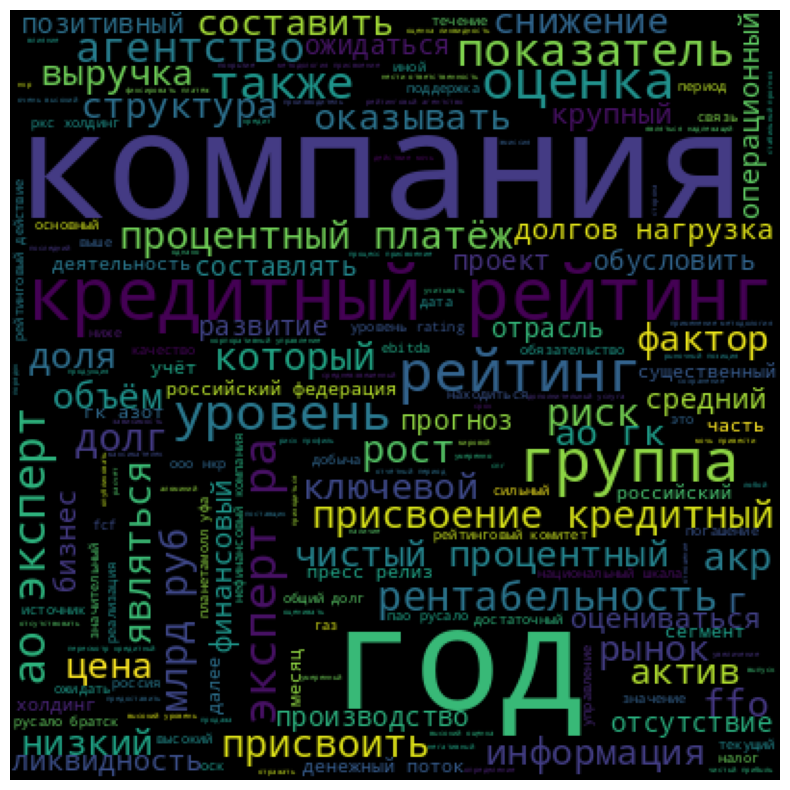

In [ ]:
nlp.word_cloud(" ".join([i for i in df["pr_txt"]]))